In [156]:
%%html
<style>
table {float: left}
</style>

# Semesterarbeit Statistische Datenanalyse

## Dokumenteninformationen


| Titel   <img width=200/> |      todo     |
|:---------|:------------- |
| Schule |  Fernfachhochschule Schweiz |
| Studiengang |    Certificate of Advanced Studies in Statistische Datenanalyse & Datenvisualisierung   |
| Kennung | DS-C-SD002.StatDa.ZH-Sa-1.PVA.FS23 |
| Semester | Frühlingssemester 2023 |
| Dozent | **Peter Tellenbach**<br>peter.tellenbach@ffhs.ch<br> |
| Autor | **Patrick Hirschi**<br>Geburtsdatum: 12.01.1990<br>Matrikelnummer: 10-179-026<br>Studierenden-ID: 200768<br>patrick-hirschi@gmx.ch<br> |

## Datenbeschaffung

### Nutzungsbedingungen

Sehr wichtig ist, dass die Nutzungsbedingungen der Datensets beachtet werden. Es gibt verschiedene Kategorien:
  * **OPEN** (offen für alle Zwecke, Quellenangabe empfohlen)
  * **OPEN BY** (offen für alle Zwecke, Quellenangabe verpflichtend)
  * **OPEN ASK** (nicht-kommerziell OK, kommerziell muss erfragt werden beim Datenlieferanten, Quellenangabe empfohlen)
  * **OPEN BY ASK** (nicht-kommerziell OK, kommerziell muss erfragt werden beim Datenlieferanten, Quellenangabe verpflichtend)
  
Sämtliche für dieses Projekt verwendeten Datensets sind in der Kategorie **OPEN** und stammen alle von derselben Quelle ([opendata.swiss](https://opendata.swiss/de/dataset/stundlich-aktualisierte-luftqualitatsmessungen-seit-19831)).

In [157]:
# import required modules
%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.dates import YearLocator,MonthLocator, DateFormatter
import locale
import calendar
import sys
import os
import glob
import datetime
import requests
from requests.exceptions import HTTPError
import pandas as pd
import numpy as np

# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go

# Profiling
from ydata_profiling import ProfileReport

# print versions
print('matplotlib: %s' % matplotlib.__version__)
print('requests: %s' % requests.__version__)
print('pandas: %s' % pd.__version__)
print('numpy: %s' % np.__version__)
print('plotly: %s' % plotly.__version__)

# log success
print(f'The module import was successful!')

matplotlib: 3.6.3
requests: 2.28.2
pandas: 1.5.3
numpy: 1.23.5
plotly: 5.14.1
The module import was successful!


### Konfiguration

Die Daten sind über URLs eindeutig beschrieben, und können so einfach neu heruntergeladen werden. Der Export ist konfigurierbar und kann auch ausgeschalten werden. Bei jedem Export werden die bereits vorhandenen Datenfiles mit einem Zeitstempel versehen und archiviert. Dies garantiert die vollständige Reproduzierbarkeit.
  
Wenn zusätzliche Datenfiles von opendata.swiss geladen werden sollen, so können die entsprechenden URLs und Filenamen ganz einfach dazukonfiguriert werden, und der Code fürs Laden der Daten muss nicht weiter angefasst werden.

In [158]:
# switch to True for reloading data or switch to False if wanting to skip 
# the reload and work with the existing data
download_new_source_data = False
# assign directory
directory = './data'
# get current datetime
datetime_now = datetime.datetime.now()
# base url
base_url = 'https://data.stadt-zuerich.ch/dataset/ugz_luftschadstoffmessung_stundenwerte/download/'
# start year
start_year = 1983
# end year
end_year = 2023

### Laden der Daten von opendata.swiss

Wenn ein (neues) Laden der Daten konfiguriert wurde, wird in einem ersten Schritt aufgeräumt. Alle vorhandenen Datenfiles im ./data Verzeichnis werden dann ins ./data/archive Verzeichnis verschoben.
  
Das python requests Modul ermöglicht es mit nur einer Zeile den entsprechenden Datensatz herunterzuladen. In der Folge wird das neue File im lokalen Filesystem erstellt.
  
Ein selektives Neuladen von nur einzelnen Files ist nicht vorgesehen, wäre aber mit paar wenigen Code-Anpassungen möglich.

In [159]:
# datetime method for logging purposes
def get_current_time_str():
    return datetime.datetime.now().strftime("%H:%M:%S.%f")

# check if data source still exists
response = requests.get(base_url)
if response.status_code == 200:
    print(f'{get_current_time_str()}: '
          f'The configured source URL is valid and the website exists.')
else:
    print(f'{get_current_time_str()}: '
          f'The configured source URL is either not valid or the website does not exist anymore.')
    # if a dataload was wanted, the new URL has to be looked up first and configured in the configuration section
    if download_new_source_data:
        print(f'{get_current_time_str()}: '
          f'You configured to reload the data from source but the source URL does not exist.'
          f'Please configure a valid source URL!')


# create data and archive directories if not existing
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f'{get_current_time_str()}: '
          f'Created the data directory {directory}.')
    # set download new source data to true for initial data load
    print(f'{get_current_time_str()}: '
          f'Set the download_new_source_data switch to True, to reload the source data to {directory}.')
    download_new_source_data = True
if not os.path.exists(directory + '/archive/'):
    os.makedirs(directory + '/archive/')
    print(f'{get_current_time_str()}: '
          f'Created the archive directory {directory}/archive/.')

# only execute this code if the switch "download_new_source_data" is set to true
if download_new_source_data:
    # iterate over old data files in the directory and archive in ./data/archive folder
    for file in os.listdir(directory):
        # join the filepath information
        fullpath = os.path.join(directory, file)
        # split the filepath into filename and fileextension
        filename = os.path.splitext(file)[0]
        fileextension = os.path.splitext(file)[1]
        # generate a datestring to add to the archived filename
        datestring = datetime_now.strftime("%Y%m%d%H%M%S") + '_'
        # checking if it is a CSV/XLSX file to avoid archiving non-data files
        if os.path.isfile(fullpath) and (fullpath.endswith('.csv') or fullpath.endswith('.xlsx')):
            print(f'{get_current_time_str()}: Found file with path: {fullpath}')
            # generate archive filename
            newpath = directory + '/archive/' + datestring + filename + fileextension
            print(f'{get_current_time_str()}: Archive filepath will be: {newpath}')
            # rename the file and move it directly to the archive directory
            os.rename(fullpath,newpath)
            print(f'{get_current_time_str()}: Successfully archived file {fullpath}'
                  f' to {newpath}!') 
            
    # download latest data files from opendata.swiss
    for x in range(start_year, end_year+1):
        try:
            # build url
            url = base_url + f'ugz_ogd_air_h1_{str(x)}.csv'
            print(f'{get_current_time_str()}: '
                  f'Try to load source data from {url} to {directory}/ugz_ogd_air_h1_{str(x)}.csv')
            # access the data file url
            response = requests.get(url, allow_redirects=True)          
            # write content to the target file
            open(os.path.join(directory, f'ugz_ogd_air_h1_{str(x)}.csv'), 'wb').write(response.content)          
            # get file stats
            file_stats = os.stat(os.path.join(directory, f'ugz_ogd_air_h1_{str(x)}.csv'))
            # If the response was successful, no Exception will be raised
            response.raise_for_status()
        except HTTPError as http_err:
            # log the details of the HTTP exception (specific catch)
            print(f'{get_current_time_str()}: HTTP error occurred while' 
                  f'downloading data file {key} from {url}: {err}') 
        except Exception as err:
            # log the details of any other exception (generic catch)
            print(f'{get_current_time_str()}: Other error occurred while'
                  f'downloading data file {key} from {url}: {err}')  
        else:
            # download and file write was succesful
            print(f'{get_current_time_str()}: Successfully loaded '
                  f'{file_stats.st_size} bytes from {url} into the data file ugz_ogd_air_h1_{str(x)}.csv!') 
else:
    # source data was intentionally not re-loaded
    print(f'{get_current_time_str()}: '
          f'No data was reloaded from source! If this was not intended, change the switch '
          f'download_new_source_data to True.') 

16:35:07.603947: The configured source URL is either not valid or the website does not exist anymore.
16:35:07.606885: No data was reloaded from source! If this was not intended, change the switch download_new_source_data to True.


In [160]:
# Get CSV files list from a folder
csv_files = glob.glob(directory + "/*.csv")

# Read each CSV file into DataFrame
print(f'{get_current_time_str()}: '
                  f'Read each CSV file into a Data Frame and add it to a list.')
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenation
print(f'{get_current_time_str()}: '
                  f'Concatenate all Data Frames from the list.')
# Concatenate all DataFrames
df_air_quality = pd.concat(df_list, ignore_index=True)

16:35:07.960857: Read each CSV file into a Data Frame and add it to a list.
16:35:07.961183: Concatenate all Data Frames from the list.


In [161]:
df_air_quality.head(5)

Datum                 Standort Parameter Intervall Einheit  \
0  1987-01-01T03:00+0100  Zch_Stampfenbachstrasse        CO        h1   mg/m3   
1  1987-01-01T03:00+0100  Zch_Stampfenbachstrasse       NO2        h1   µg/m3   
2  1987-01-01T03:00+0100  Zch_Stampfenbachstrasse        NO        h1   µg/m3   
3  1987-01-01T03:00+0100  Zch_Stampfenbachstrasse       NOx        h1     ppb   
4  1987-01-01T03:00+0100  Zch_Stampfenbachstrasse        O3        h1   µg/m3   

    Wert     Status  
0   0.10  bereinigt  
1  33.42  bereinigt  
2   6.18  bereinigt  
3  22.43  bereinigt  
4  39.90  bereinigt

## Datenaufbereitung

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


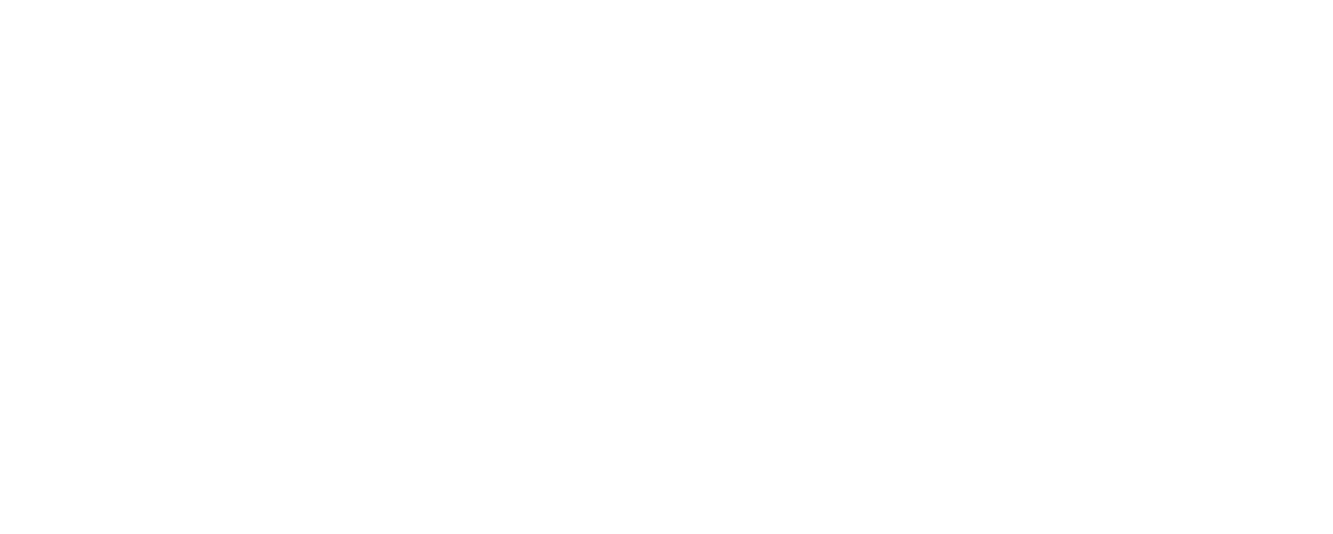

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


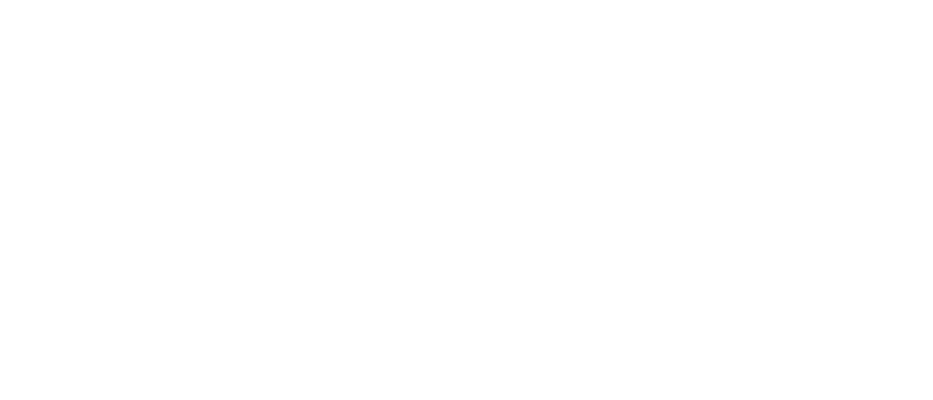

<IPython.core.display.Javascript object>


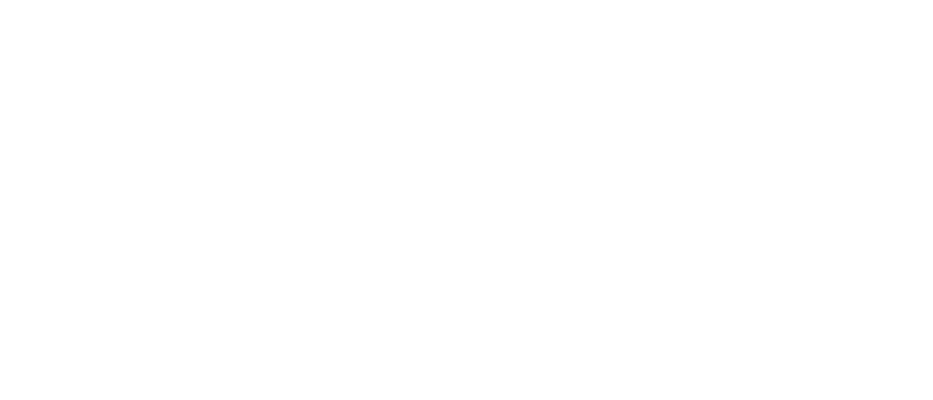

<IPython.core.display.Javascript object>


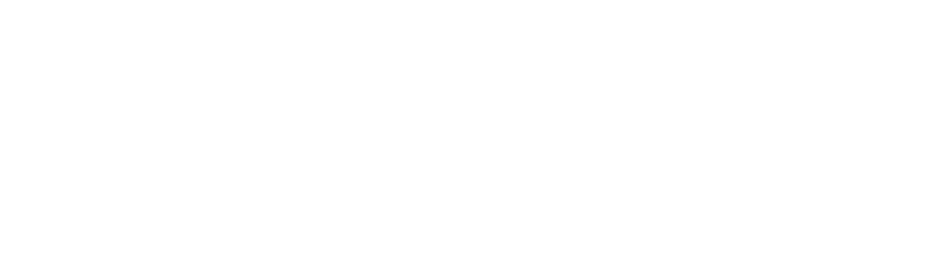

<IPython.core.display.Javascript object>


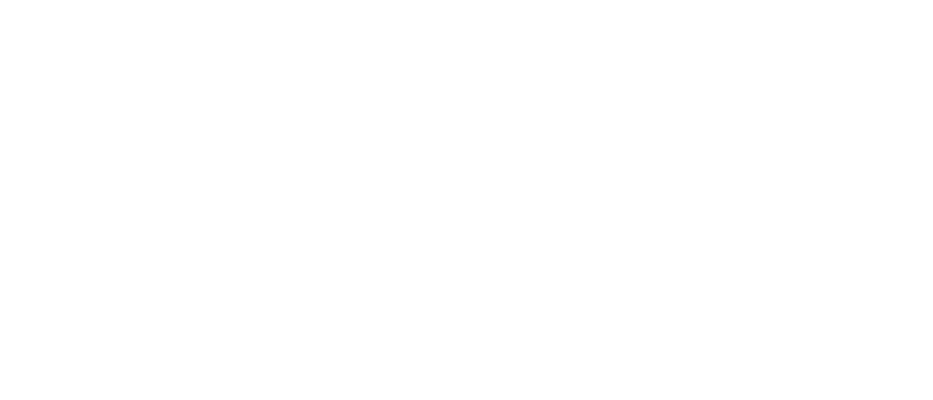

<IPython.core.display.Javascript object>


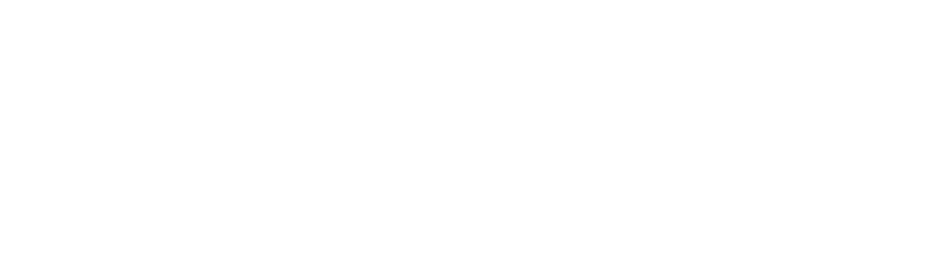

<IPython.core.display.Javascript object>


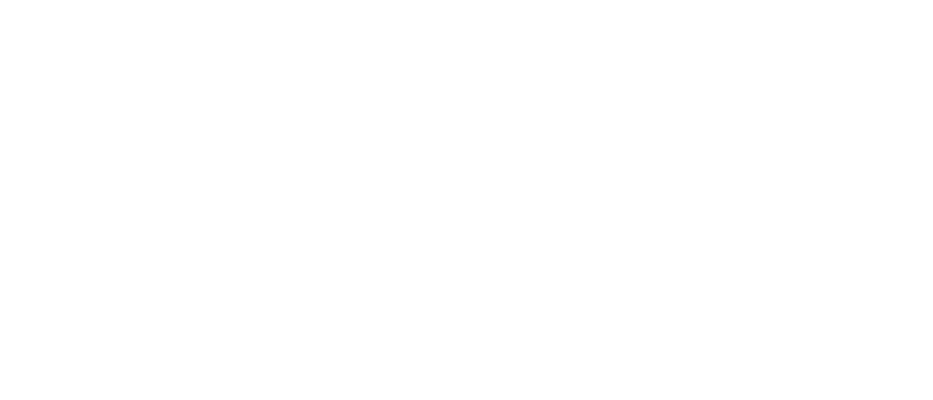

<IPython.core.display.Javascript object>


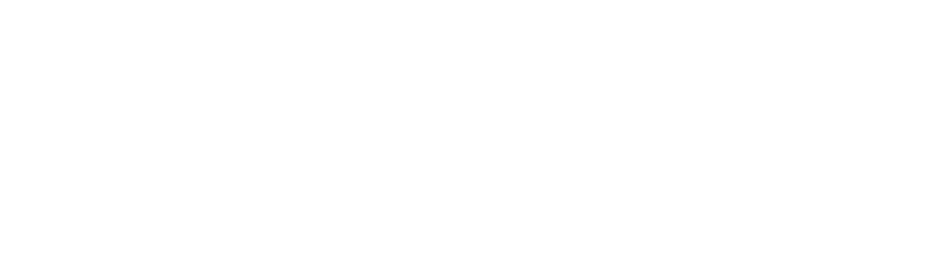

<IPython.core.display.Javascript object>


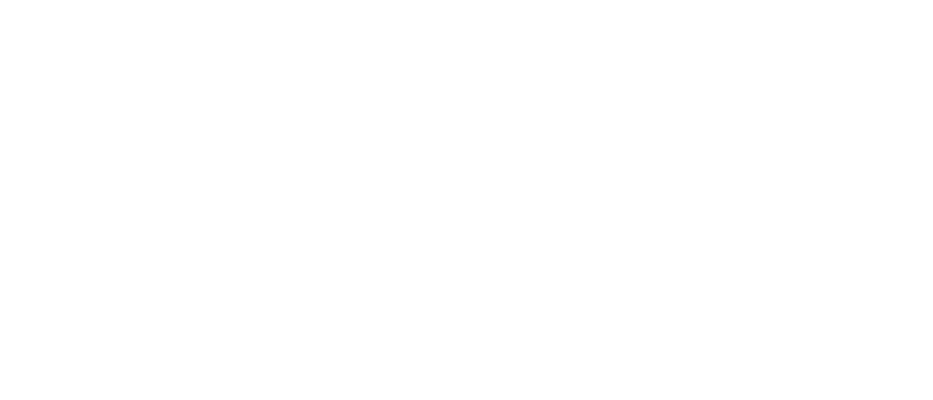

<IPython.core.display.Javascript object>


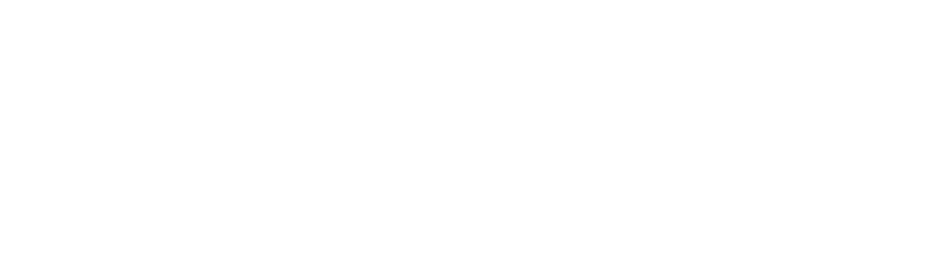

<IPython.core.display.Javascript object>


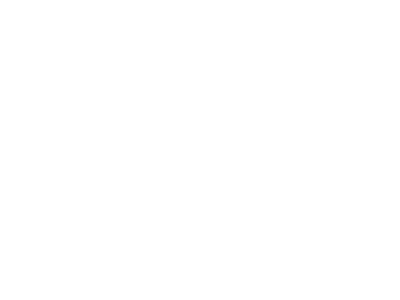

<IPython.core.display.Javascript object>


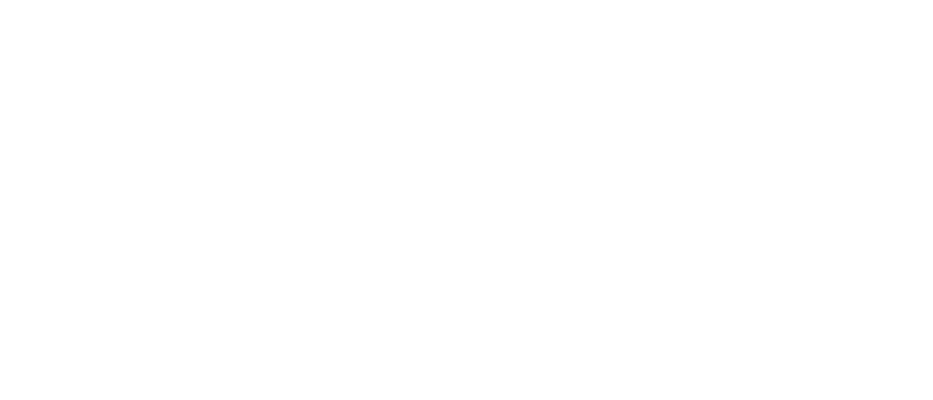

<IPython.core.display.Javascript object>


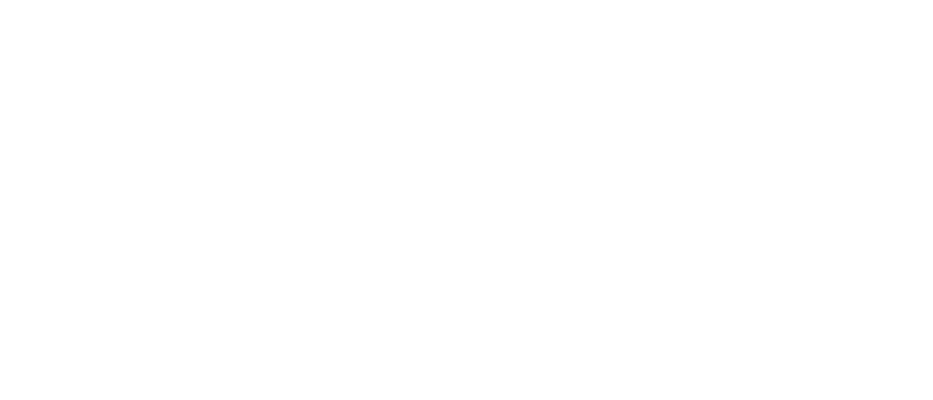

<IPython.core.display.Javascript object>


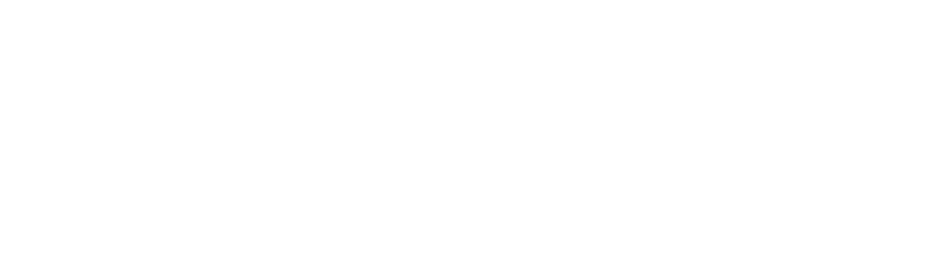

<IPython.core.display.Javascript object>


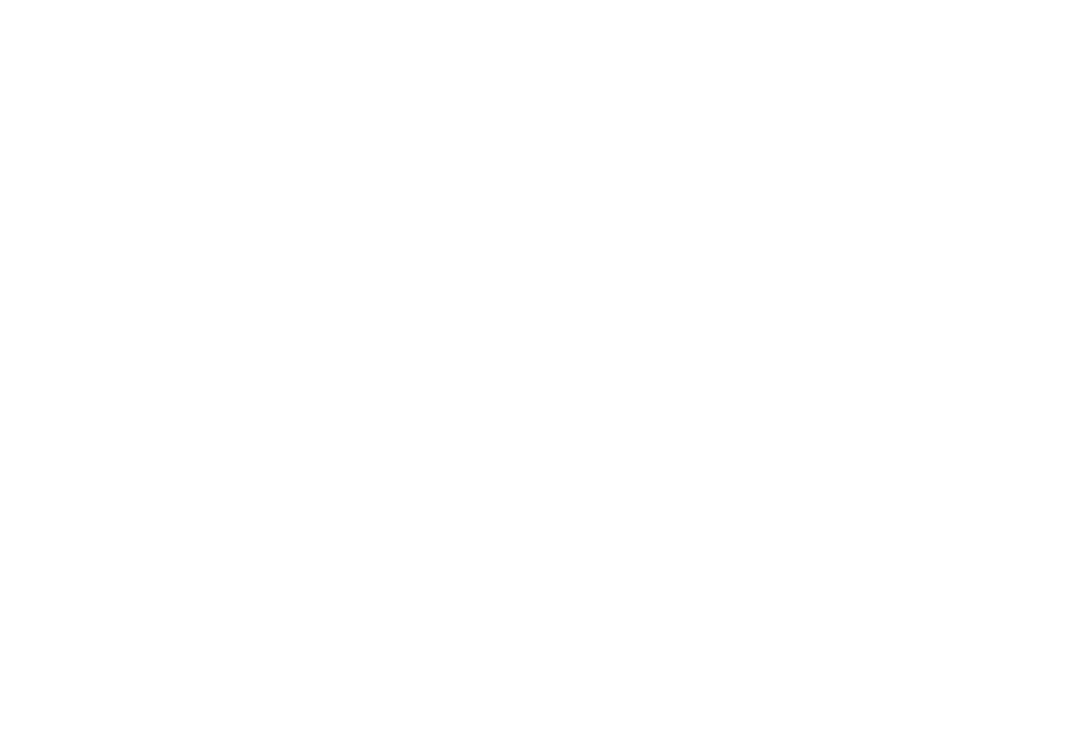

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [227]:
profile = ProfileReport(df_air_quality, title="Profiling Report")
profile.to_notebook_iframe()

Für das Plotten der Daten ist es einfacher, wenn pro Datumswert die verschiedenen Parameter der Luftqualitätsmessungen als Spalten abgebildet sind. Um das effizient hinzukriegen, sollten zuerst die verschiedenen Werte auf eine Einheit pro Parameter umgerechnet werden. Mit dem folgenden Statement kann man die verschiedenen Parameter-Einheit Kombinationen abfragen.

In [167]:
df_air_quality[['Parameter', 'Einheit']].value_counts().reset_index(name='count')

Parameter Einheit   count
0        O3   µg/m3  927123
1        NO   µg/m3  878651
2       NOx     ppb  878627
3       NO2   µg/m3  878623
4      PM10   µg/m3  431778
5        CO   mg/m3  353633
6       SO2   µg/m3  353335
7     PM2.5   µg/m3  157000

Das Resultat zeigt, dass glücklicherweise pro Parameter immer in derselben Einheit gemessen wurde, oder alternativ bereits eine Normierung stattfand. So kann die Einheit bei der Pivotierung ausgelassen und separat notiert werden. Das spart die Erstellung von acht Spalten. 

In [168]:
# filter for location Stampfenbachstrasse
df_air_quality_zch_stmpf = df_air_quality.query("Standort == 'Zch_Stampfenbachstrasse'")
# filter for definite/approved values (Status "bereinigt")
df_air_quality_zch_stmpf = df_air_quality_zch_stmpf.query("Status == 'bereinigt'")
# drop unnecessary columns
df_air_quality_zch_stmpf = df_air_quality_zch_stmpf.drop(columns=['Intervall', 'Status', 'Einheit','Standort'])

# pivot the Parameter column to create columns for each Parameter type
df_air_quality_zch_stmpf_clean = df_air_quality_zch_stmpf.pivot(index = 'Datum', 
                                                                columns = 'Parameter', 
                                                                values = 'Wert')
# check the output
df_air_quality_zch_stmpf_clean

Parameter                CO      NO    NO2     NOx     O3   PM10  PM2.5  \
Datum                                                                     
1983-01-01T00:00+0100  4.09  211.32  64.25  203.02    NaN    NaN    NaN   
1983-01-01T01:00+0100  5.41  381.91  58.09  336.57    NaN    NaN    NaN   
1983-01-01T02:00+0100  7.18  460.77  52.44  396.84    NaN    NaN    NaN   
1983-01-01T03:00+0100  5.64  314.40  59.12  282.98    NaN    NaN    NaN   
1983-01-01T04:00+0100  4.23  221.11  64.25  210.87    NaN    NaN    NaN   
...                     ...     ...    ...     ...    ...    ...    ...   
2022-12-31T19:00+0100  0.34    5.57  30.89   20.62  13.15  14.36  11.16   
2022-12-31T20:00+0100  0.32    2.76  25.97   15.79  15.56  19.67  14.79   
2022-12-31T21:00+0100  0.36    5.45  30.41   20.27  10.33  29.58  23.84   
2022-12-31T22:00+0100  0.43   17.86  38.97   34.70   5.27  45.87  37.44   
2022-12-31T23:00+0100  0.43   24.01  40.87   40.63   6.12  45.79  37.99   

Parameter                 SO2  
Datum                          
1983-01-01T00:00+0100  126.44  
1983-01-01T01:00+0100  129.01  
1983-01-01T02:00+0100  116.67  
1983-01-01T03:00+0100  108.46  
1983-01-01T04:00+0100  113.60  
...                       ...  
2022-12-31T19:00+0100    1.23  
2022-12-31T20:00+0100    1.35  
2022-12-31T21:00+0100    1.37  
2022-12-31T22:00+0100    1.50  
2022-12-31T23:00+0100    1.83  

[350637 rows x 8 columns]

Für die Analyse werden nun die monatlichen Durchschnittswerte in jedem Jahr berechnet.

In [169]:
# Convert the datetime column to datetime format
df_air_quality_zch_stmpf_clean.index = pd.to_datetime(df_air_quality_zch_stmpf_clean.index)

df_air_quality_zch_stmpf_clean_monthly_mean = df_air_quality_zch_stmpf_clean.resample('M').mean()
df_air_quality_zch_stmpf_clean_monthly_mean.index = df_air_quality_zch_stmpf_clean_monthly_mean.index.tz_localize(None).to_period('M').to_timestamp()

df_air_quality_zch_stmpf_clean_monthly_mean

Parameter         CO          NO        NO2         NOx         O3       PM10  \
Datum                                                                           
1983-01-01  3.694595  162.235459  38.538595  150.223581        NaN        NaN   
1983-02-01  2.321649  156.805622  47.716327  150.669430        NaN        NaN   
1983-03-01  2.456581  172.011041  48.005892  163.011649        NaN        NaN   
1983-04-01  1.734177   58.097626  20.097418   57.088925        NaN        NaN   
1983-05-01  2.149365  103.543122  59.696689  114.232041        NaN        NaN   
...              ...         ...        ...         ...        ...        ...   
2022-08-01  0.214474    3.695514  14.991595   10.802432  76.571507  12.725712   
2022-09-01  0.211450    5.214951  16.754490   12.942448  51.385852   9.104278   
2022-10-01  0.299865   14.410946  22.878000   23.517527  23.004399  18.247131   
2022-11-01  0.285154   14.180531  24.774441   24.324246  25.738106  11.038312   
2022-12-01  0.325599   15.609744  28.473140   27.404272  21.761199  16.488123   

Parameter       PM2.5         SO2  
Datum                              
1983-01-01        NaN   84.384788  
1983-02-01        NaN  100.260410  
1983-03-01        NaN   68.517220  
1983-04-01        NaN   33.432657  
1983-05-01        NaN   23.614220  
...               ...         ...  
2022-08-01   7.904489    1.130054  
2022-09-01   5.405514    1.257259  
2022-10-01   9.645697    1.356108  
2022-11-01   7.523612    1.179106  
2022-12-01  13.378771    1.176213  

[480 rows x 8 columns]

Über alle Monate und den ganzen Zeitraum von 1983-2023 ergibt sich so der folgende Verlauf für die Werte Stickstoffmonoxid (NO) und Kohlenmonoxid (CO).

<IPython.core.display.Javascript object>


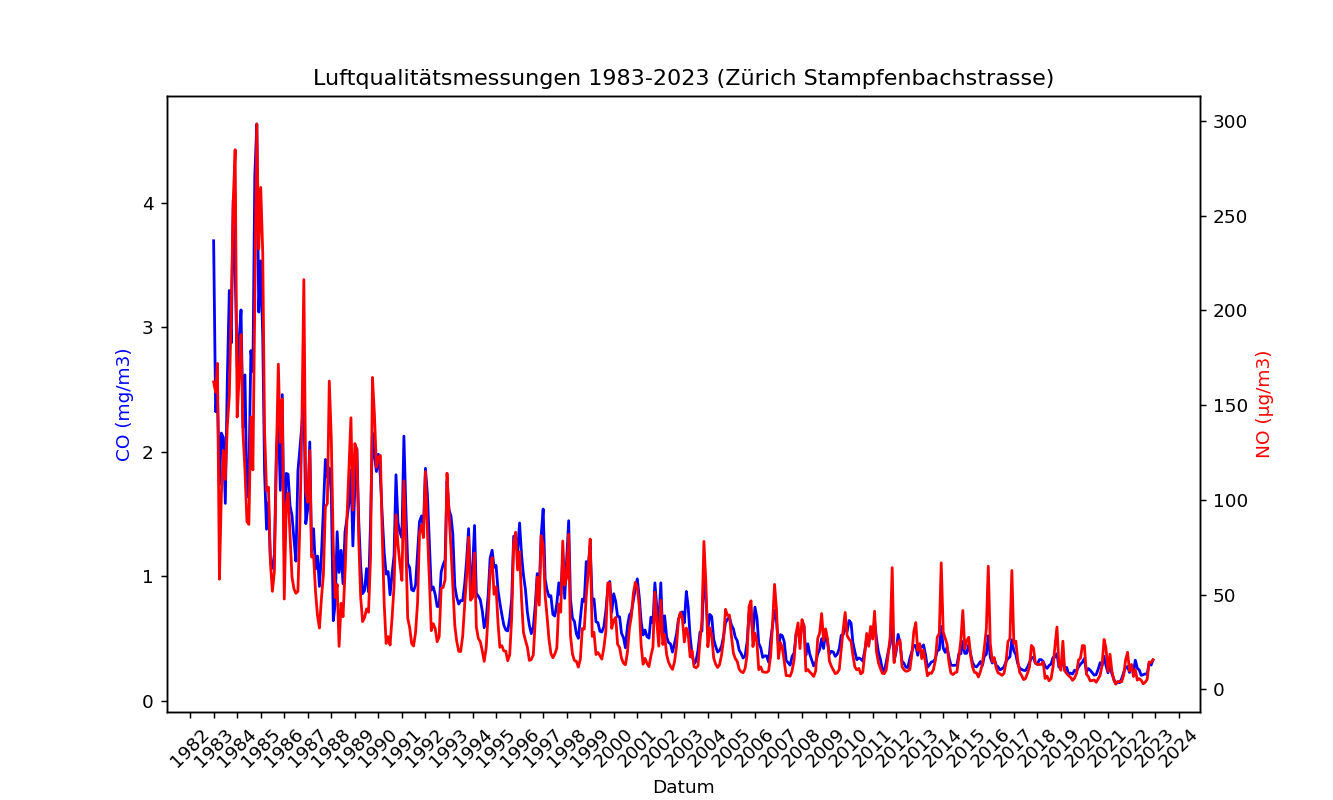

In [170]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first measurement with the primary y-axis
ax.plot(df_air_quality_zch_stmpf_clean_monthly_mean.index, df_air_quality_zch_stmpf_clean_monthly_mean['CO'], color='blue')
ax.set_ylabel('CO (mg/m3)', color='blue')

# Create a secondary y-axis and plot the second measurement
ax2 = ax.twinx()
ax2.plot(df_air_quality_zch_stmpf_clean_monthly_mean.index, df_air_quality_zch_stmpf_clean_monthly_mean['NO'], color='red')
ax2.set_ylabel('NO (µg/m3)', color='red')

# Set the chart title and x-axis label
ax.set_title('Luftqualitätsmessungen 1983-2023 (Zürich Stampfenbachstrasse)')
ax.set_xlabel('Datum')
# Rotate the x-axis labels by 45 degrees
ax.tick_params(axis='x', rotation=45)

# Set the x-axis tick frequency to monthly
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Show the chart
plt.show()

Für die Analyse ist es interessanter, wenn man die Werte jeweils für die einzelnen Monate über alle Jahre darstellt (z.B. eine Grafik für alle Januarmonate von 1983-2023).

<IPython.core.display.Javascript object>


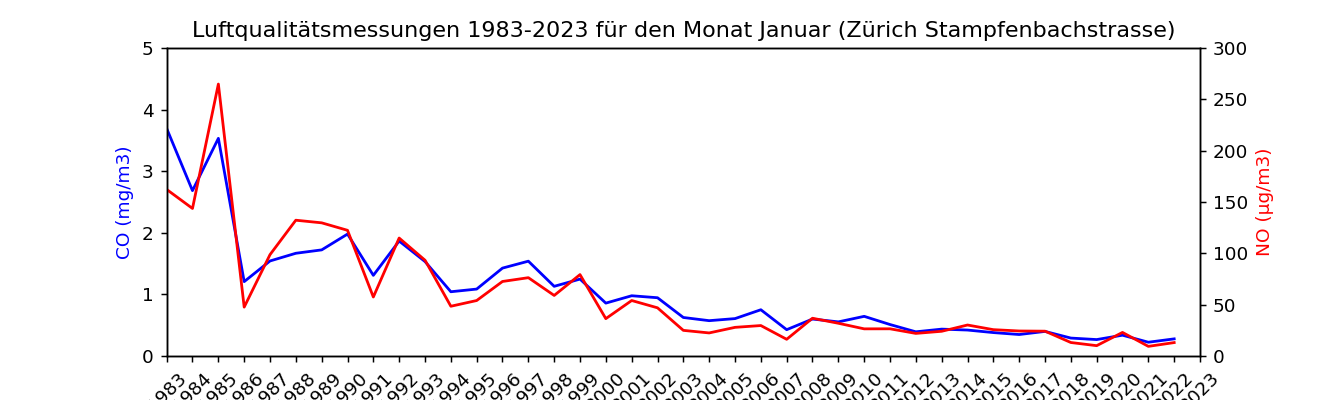

<IPython.core.display.Javascript object>


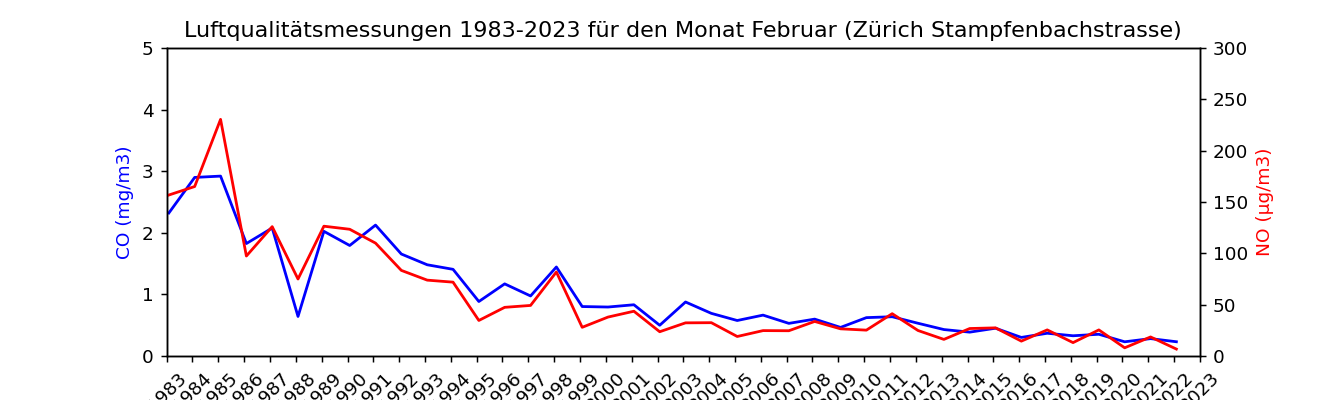

<IPython.core.display.Javascript object>


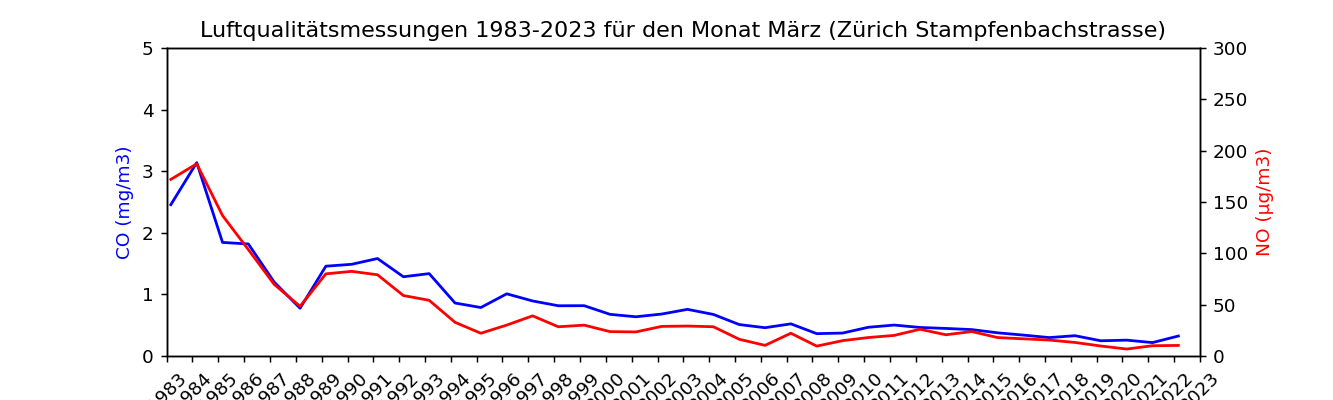

<IPython.core.display.Javascript object>


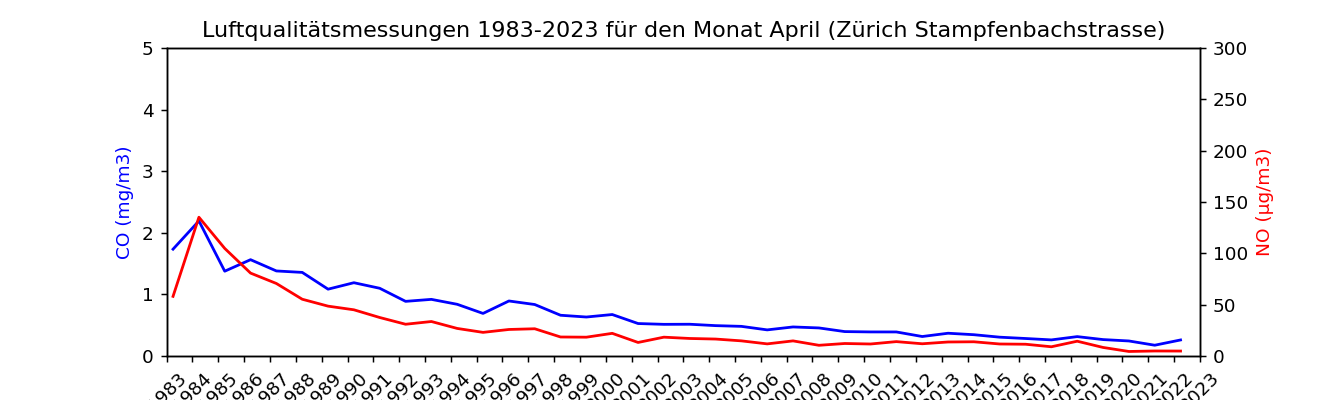

<IPython.core.display.Javascript object>


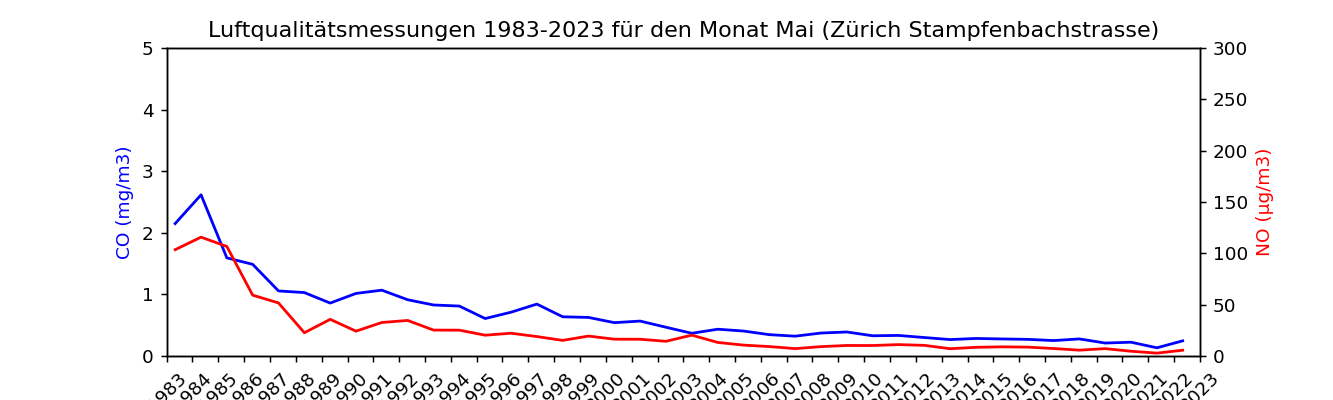

<IPython.core.display.Javascript object>


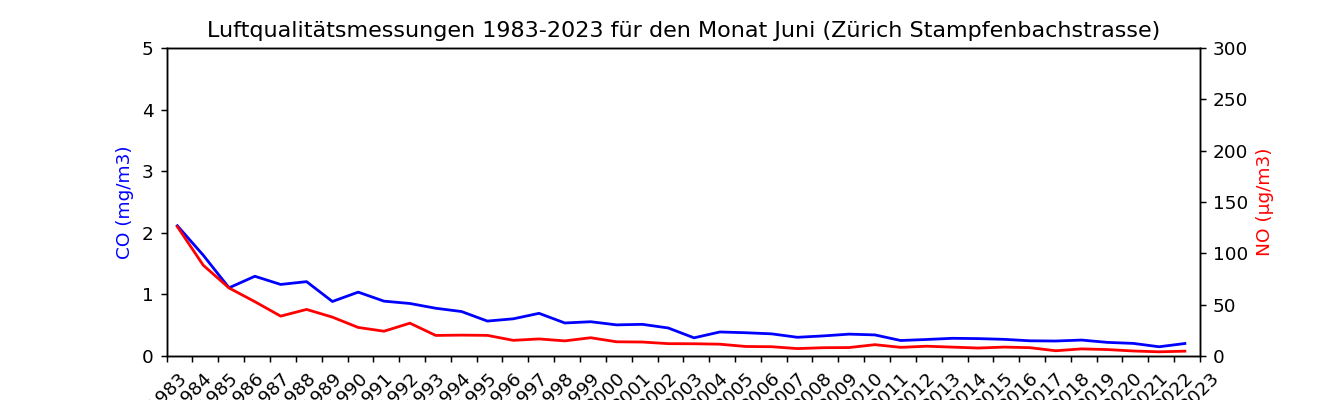

<IPython.core.display.Javascript object>


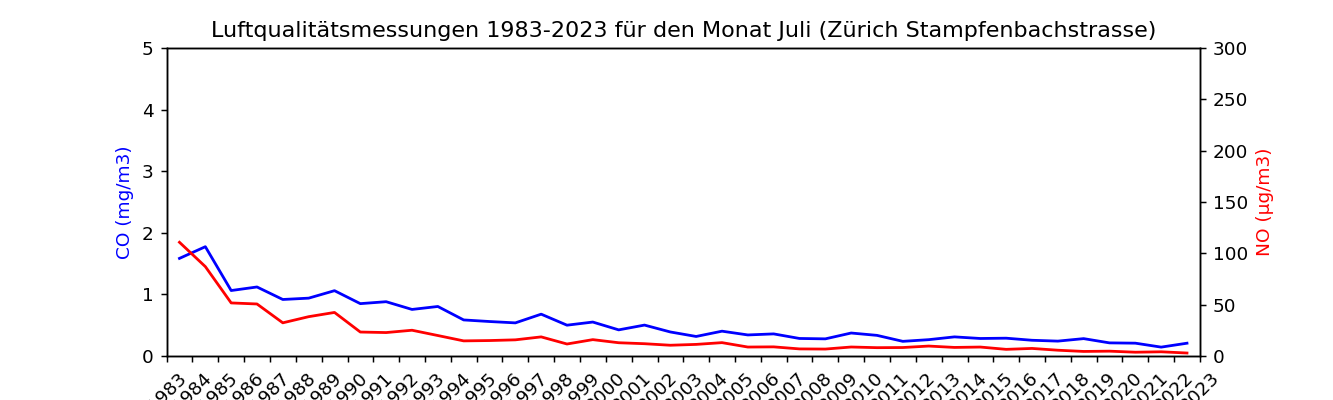

<IPython.core.display.Javascript object>


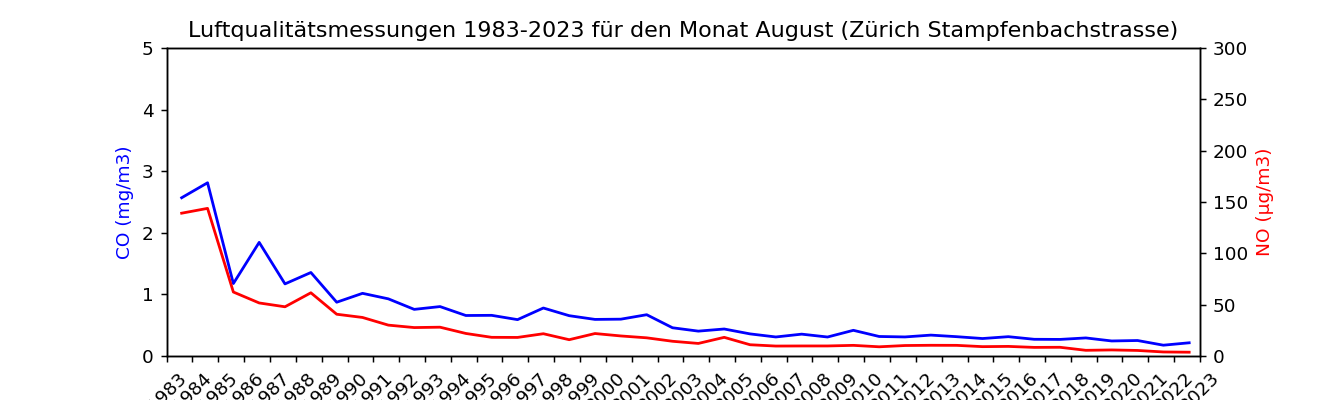

<IPython.core.display.Javascript object>


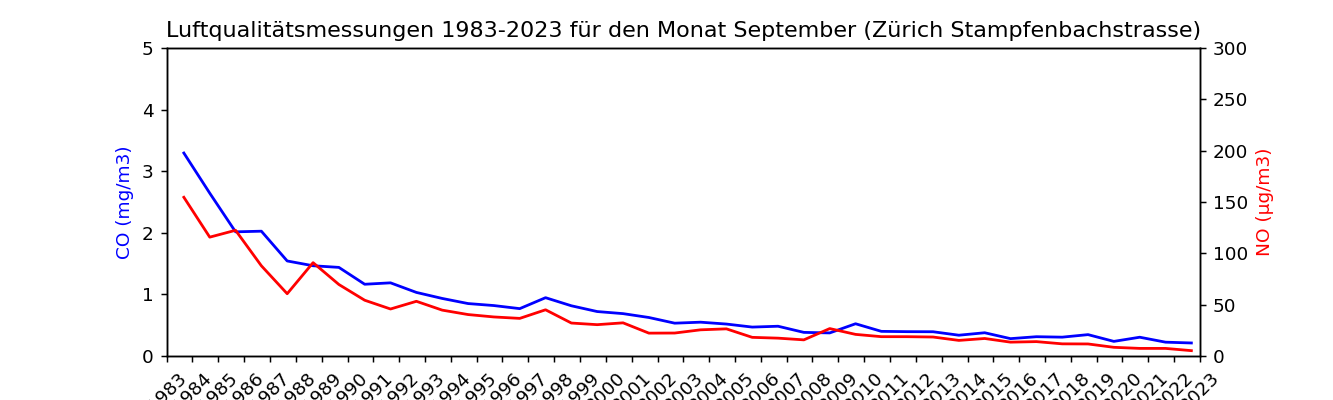

<IPython.core.display.Javascript object>


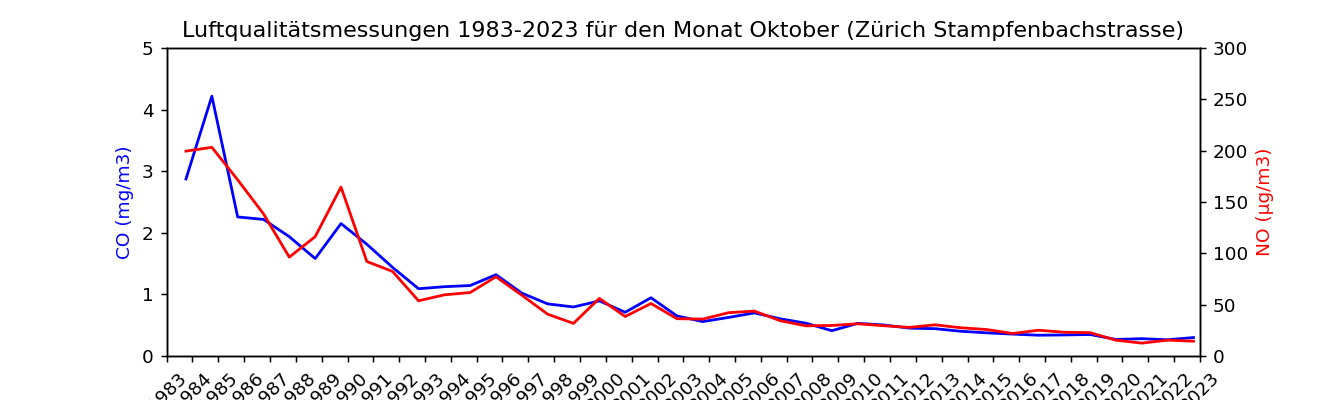

<IPython.core.display.Javascript object>


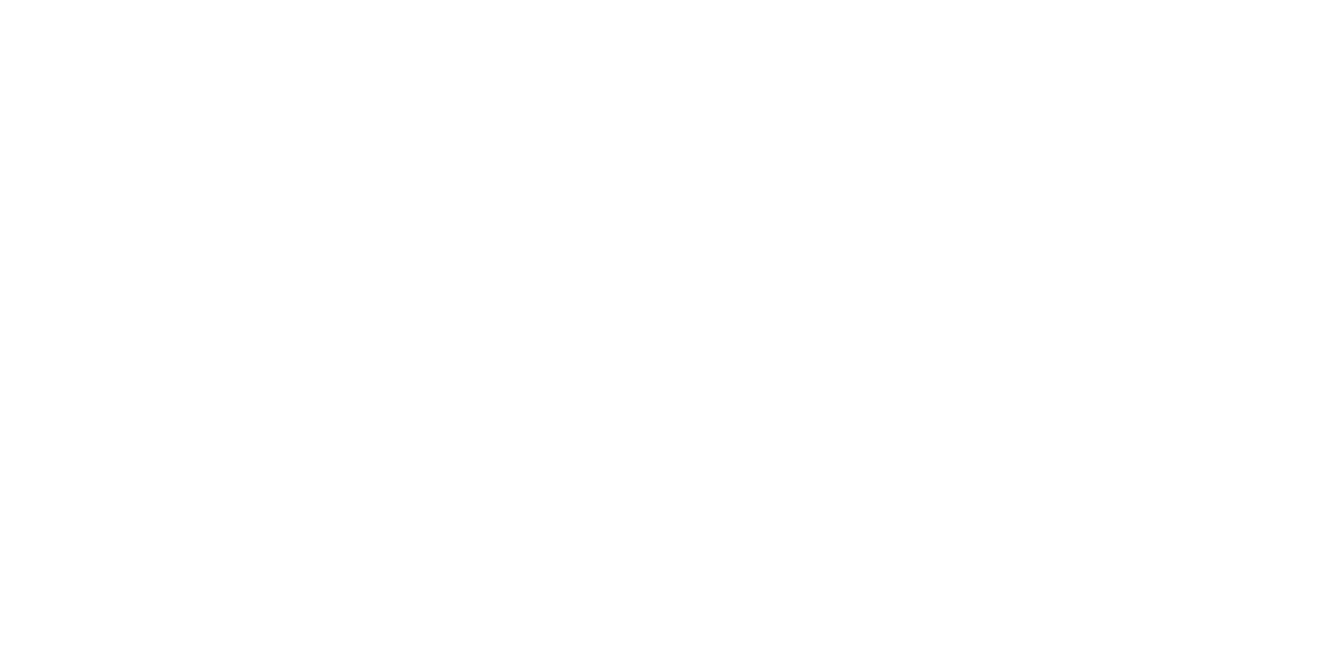

<IPython.core.display.Javascript object>


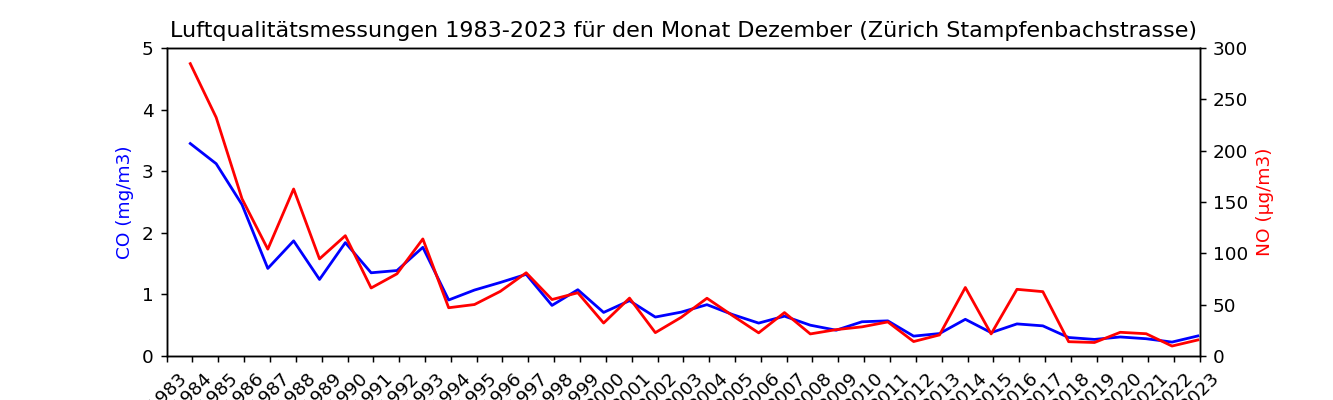

In [171]:
# Set the locale to German
locale.setlocale(locale.LC_TIME, "de_DE.utf-8")
# Set the x-axis and y-axis limits for all charts
xlim = pd.Timestamp('1983-01-01'), pd.Timestamp('2023-01-01')
ylim_co = 0, 5
ylim_no = 0, 300

for month in range(1, 13):
    # Filter the DataFrame for the current month
    month_df = df_air_quality_zch_stmpf_clean_monthly_mean.loc[df_air_quality_zch_stmpf_clean_monthly_mean.index.month == month]
    
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot the first measurement with the primary y-axis
    ax.plot(month_df.index, month_df['CO'], color='blue')
    ax.set_ylabel('CO (mg/m3)', color='blue')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim_co)

    # Create a secondary y-axis and plot the second measurement
    ax2 = ax.twinx()
    ax2.plot(month_df.index, month_df['NO'], color='red')
    ax2.set_ylabel('NO (µg/m3)', color='red')
    ax2.set_ylim(ylim_no)

    # Set the chart title and x-axis label
    ax.set_title(f'Luftqualitätsmessungen 1983-2023 für den Monat {calendar.month_name[month]} (Zürich Stampfenbachstrasse)')
    ax.set_xlabel('Datum')
    # Rotate the x-axis labels by 45 degrees
    ax.tick_params(axis='x', rotation=45)

    # Set the x-axis tick frequency to monthly
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))

    # Show the chart
    plt.show()

Nun soll für die Stickstoffmonoxidmessungen der Prototyp der finalen Visualisierung erstellt werden. Dafür wurde ein Kreis-/Spiralen-/Polardiagramm ausgesucht (Vorlage: https://www.dataquest.io/blog/climate-temperature-spirals-python/). Die verschiedenen Jahre werden animiert und in einem matplotlib Polar-Diagramm dargestellt. Das Polardiagramm wurde dafür aufgeteilt für die verschiedenen Monate (360 Grad bzw. 30 Grad pro Monat). Das Zentrum des Diagrammes bezeichnet den Nullpunkt (0 µg/m3 Stickstoffmonoxid). Je näher sich ein Punkt am Zentrum befindet, desto besser also.

<IPython.core.display.Javascript object>


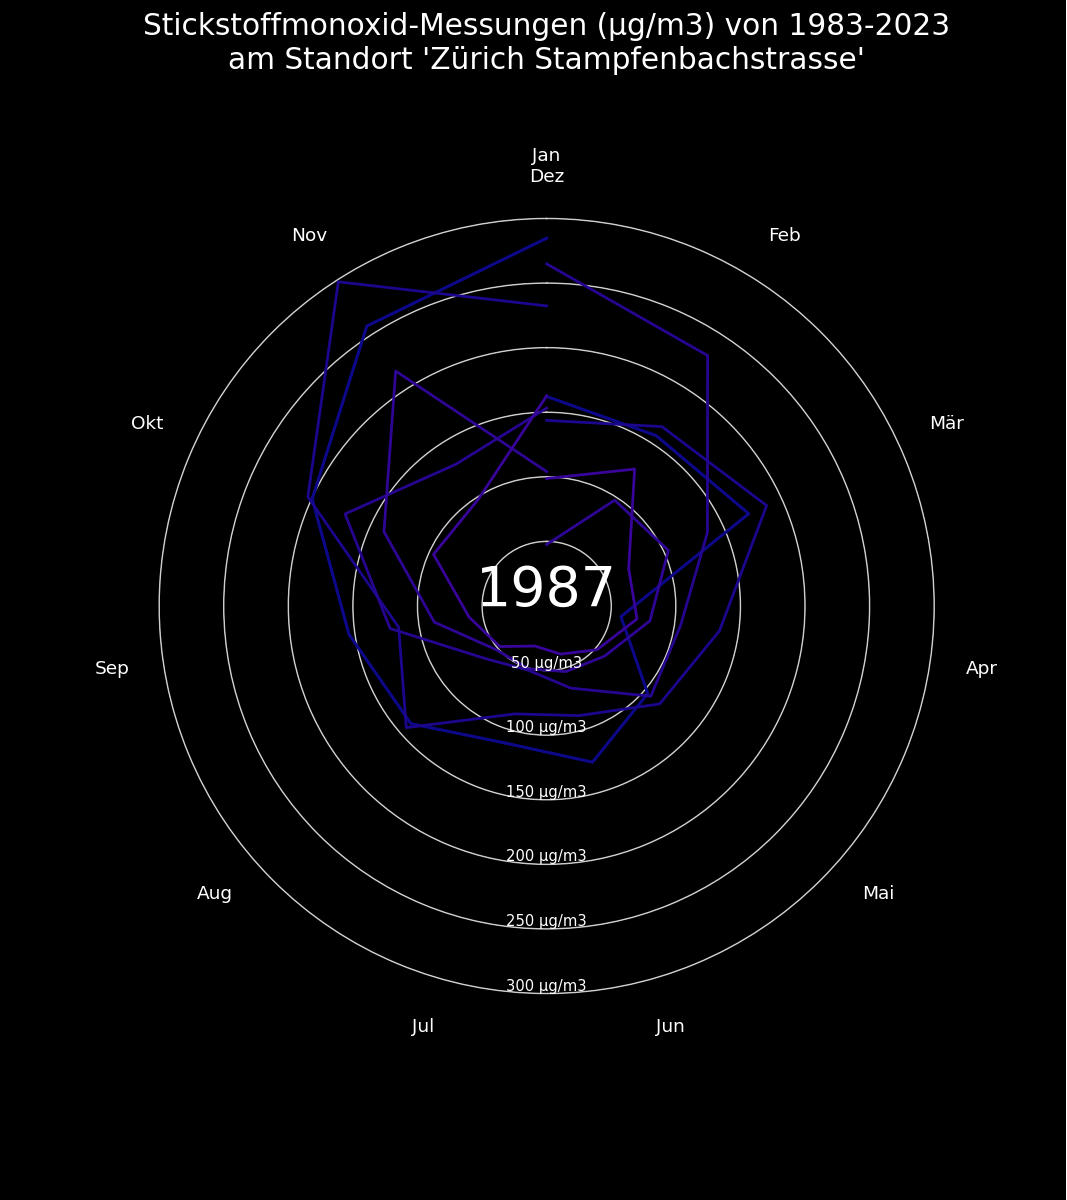

In [233]:
# Color Configuration
label_color = 'white'
polar_bg_color = 'black'
figure_bg_color = 'black'
title_color = 'white'
line_color = 'white'

# calculate theta (to split the circle into 12 pieces of uniform size later)
theta = np.linspace(0, 2*np.pi, 12)
# get the years included in the dataset
years = df_air_quality_zch_stmpf_clean_monthly_mean.index.year.unique()
# generate the labels for the different months
months = [month[:3] for month in calendar.month_name[2:12]]
# january and december are at the same place, thats why the labels are merged
months.insert(0, 'Jan\nDez')
months.insert(11,'')

# Create the base plot
fig = plt.figure(figsize=(8,9))
# change the color of the background figure
fig.set_facecolor(figure_bg_color)

# setup the polar diagram
ax1 = plt.subplot(111, projection='polar')
# remove the labels of the y-axis
ax1.axes.get_yaxis().set_ticklabels([])
# set the x-ticks
ax1.set_xticks(theta)
# set the xticklabels
ax1.set_xticklabels(months)
# change the labels color
ax1.tick_params(axis='x', colors=label_color)
# change the color of the polar diagram
ax1.set_facecolor(polar_bg_color)
# Create the text object
text = ax1.text(0, 0, "1983", c=label_color, size=30, ha='center')
# set the title of the diagram
ax1.set_title("Stickstoffmonoxid-Messungen (µg/m3) von 1983-2023\nam Standort 'Zürich Stampfenbachstrasse'\n\n", c=title_color , fontdict={'fontsize': 16})
# set the size of the scale for the y-axis
ax1.set_ylim(0, 320)
# Set rotation angle to 90 degrees
ax1.set_theta_offset(np.pi/2)
# Set the direction of the angle to clockwise
ax1.set_theta_direction(-1) 
# remove the grid of the x-axis
ax1.xaxis.grid(False)

# create the lines for the NO values (ranging from 0 to 300 µg/m3)
full_circle_thetas = np.linspace(0, 2*np.pi, 1000)
line_one_radii = [0]*1000
line_two_radii = [50]*1000
line_three_radii = [100]*1000
line_four_radii = [150]*1000
line_five_radii = [200]*1000
line_six_radii = [250]*1000
line_seven_radii = [300]*1000

# plot the lines for the NO values (ranging from 0 to 300 µg/m3)
ax1.plot(full_circle_thetas, line_one_radii, c=line_color, linewidth=0.2)
ax1.plot(full_circle_thetas, line_two_radii, c=line_color, linewidth=0.2)
ax1.plot(full_circle_thetas, line_three_radii, c=line_color, linewidth=0.2)
ax1.plot(full_circle_thetas, line_four_radii, c=line_color, linewidth=0.2)
ax1.plot(full_circle_thetas, line_five_radii, c=line_color, linewidth=0.2)
ax1.plot(full_circle_thetas, line_six_radii, c=line_color, linewidth=0.2)
ax1.plot(full_circle_thetas, line_seven_radii, c=line_color, linewidth=0.2)

# draw the labels for the NO values (ranging from 0 to 300 µg/m3)
#ax1.text(np.pi/2, 0, "0 µg/m3", color="white", ha='center', va='bottom', fontdict={'fontsize': 6})
ax1.text(np.pi, 50, "50 µg/m3", c=label_color, ha='center', va='bottom', fontdict={'fontsize': 8})
ax1.text(np.pi, 100, "100 µg/m3", c=label_color, ha='center', va='bottom', fontdict={'fontsize': 8})
ax1.text(np.pi, 150, "150 µg/m3", c=label_color, ha='center', va='bottom', fontdict={'fontsize': 8})
ax1.text(np.pi, 200, "200 µg/m3", c=label_color, ha='center', va='bottom', fontdict={'fontsize': 8})
ax1.text(np.pi, 250, "250 µg/m3", c=label_color, ha='center', va='bottom', fontdict={'fontsize': 8})
ax1.text(np.pi, 300, "300 µg/m3", c=label_color, ha='center', va='bottom', fontdict={'fontsize': 8})

def update(i):
    # Specify how we want the plot to change in each frame.
    # We need to unravel the for loop we had earlier.
    year = years[i]
    r = df_air_quality_zch_stmpf_clean_monthly_mean[df_air_quality_zch_stmpf_clean_monthly_mean.index.year == year]['NO']
    ax1.plot(theta, r, c=plt.cm.plasma(i*5))
    text.set_text(str(year))
    return ax1

anim = FuncAnimation(fig, update, frames=len(years), interval=400, blit=True)

#anim.save('zch_stmpfb_no_1983_2023.gif', dpi=120, writer='imagemagick')